In [1]:
from IPython.display import HTML
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymysql
plt.style.use('Solarize_Light2')
%matplotlib inline
# Increase default figure and font sizes for easier viewing.
plt.rcParams['figure.figsize'] = (16, 9)
plt.rcParams['font.size'] = 14

In [2]:
host = 'host'
database = 'database'
user = 'user'
passw = 'passw'

tenure_query = """
SELECT enrol.dob, enrol.ongoingFnDirectDebitTotal, DATEDIFF(cxl.createDate, enrol.createDate) as tenure, cxl.nps, enrol.zip 
FROM EnrolmentSubmissionData enrol 
INNER JOIN CancellationSubmissionData cxl ON enrol.phone = cxl.phone AND enrol.email = cxl.email 
WHERE DATEDIFF(cxl.createDate, enrol.createDate) > 0
AND cxl.nps IS NOT NULL
AND enrol.ongoingFnDirectDebitTotal IS NOT NULL
AND enrol.dob IS NOT NULL
ORDER BY 2 DESC;
"""

conn = pymysql.connect(host = host, db=database, user=user, password=passw)
tenure_data = pd.read_sql(tenure_query, con=conn)
tenure_data.columns = ['DOB','Membership_Value','Tenure','NPS','Zip']
conn.close()

In [3]:
tenure_data['DOB'] = pd.to_datetime(tenure_data['DOB'])
tenure_data['Age'] = datetime.now().year - tenure_data['DOB'].dt.year

In [4]:
tenure_data['Membership_Value'] = pd.to_numeric(tenure_data['Membership_Value'])
tenure_data['NPS'] = pd.to_numeric(tenure_data['NPS'])

In [5]:
tenure_data.isnull().sum()

DOB                 0
Membership_Value    0
Tenure              0
NPS                 0
Zip                 0
Age                 0
dtype: int64

In [6]:
tenure_data.dtypes

DOB                 datetime64[ns]
Membership_Value           float64
Tenure                       int64
NPS                          int64
Zip                         object
Age                          int64
dtype: object

In [7]:
tenure_data.describe()

,Membership_Value,Tenure,NPS,Age
count,1551.000000,1551.000000,1551.000000,1551.000000
mean,50.550870,90.740812,9.120567,28.996776
std,30.286851,77.971061,1.762047,7.319835
min,27.400000,1.000000,1.000000,14.000000
25%,35.400000,21.000000,9.000000,24.000000
50%,41.400000,73.000000,10.000000,28.000000
75%,59.400000,144.500000,10.000000,32.000000
max,389.400000,351.000000,10.000000,67.000000


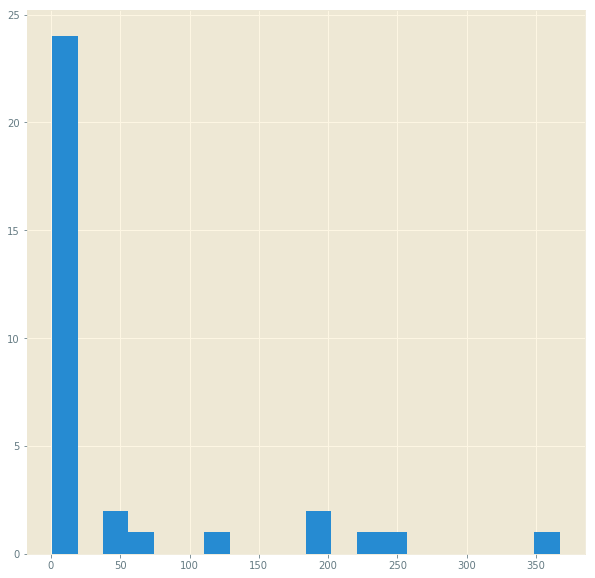

In [25]:
fig, ax = plt.subplots(figsize=(10,10))
tenure_data.Membership_Value.value_counts().hist(bins=20)

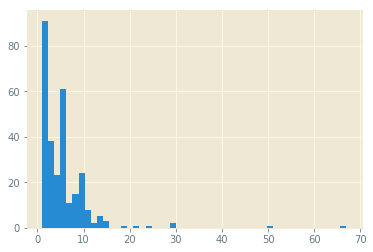

In [26]:
tenure_data.Tenure.value_counts().hist(bins=50)

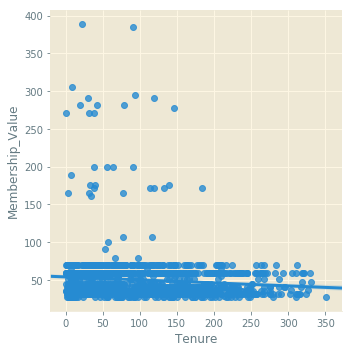

In [10]:
sns.lmplot(x='Tenure', y='Membership_Value', data=tenure_data)
plt.show()

In [11]:
# tenure_data['memberships_under_100'] = tenure[[tenure_data['Membership_Value' < 100.0]]]
# tenure_data['Membership_Value' < 100.0]
# users[users.age < 20]
tenure_data_under_100 = tenure_data[tenure_data.Membership_Value < 100]

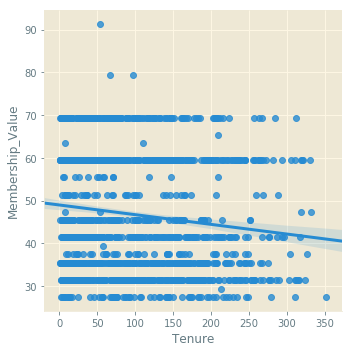

In [12]:
sns.lmplot(x='Tenure', y='Membership_Value', data=tenure_data_under_100)
plt.show()

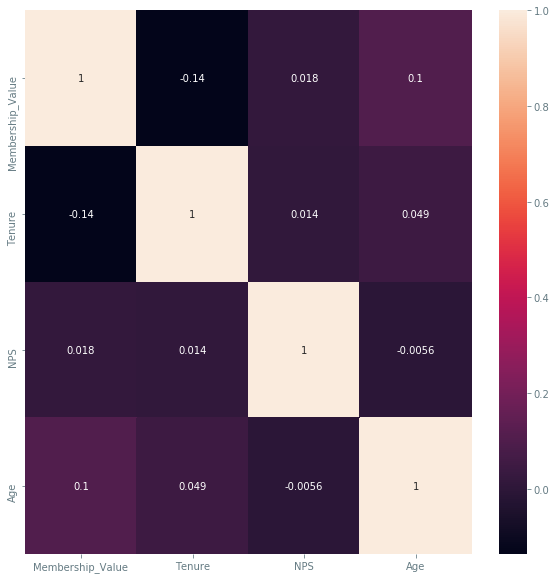

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(tenure_data.corr(method='spearman'),annot=True)

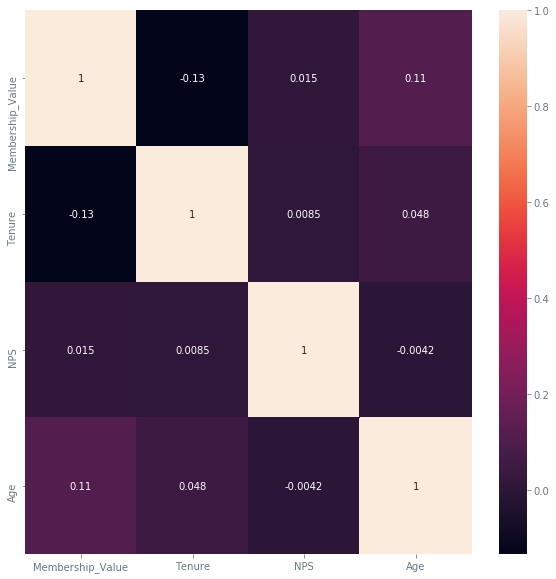

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(tenure_data_under_100.corr(method='spearman'),annot=True)

In [15]:
tenure_data.columns

Index(['DOB', 'Membership_Value', 'Tenure', 'NPS', 'Zip', 'Age'], dtype='object')

In [16]:
features = ['Age','Membership_Value','NPS','Tenure']
tenure_md1 = pd.get_dummies(tenure_data[features], drop_first = True)
# features = ['Membership_Value']
X = tenure_md1[features].drop('Tenure', axis=1)
y = tenure_md1.Tenure

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=99)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [18]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [19]:

lr_70_30 = LinearRegression()
lr_70_30.fit(X_train,y_train)
lr_70_30.score(X_test, y_test)

0.01598560281779704

In [20]:
print(lr_70_30.intercept_)
print(lr_70_30.coef_)

90.78709677419354
[ 3.93393994 -7.67812184  2.56657127]


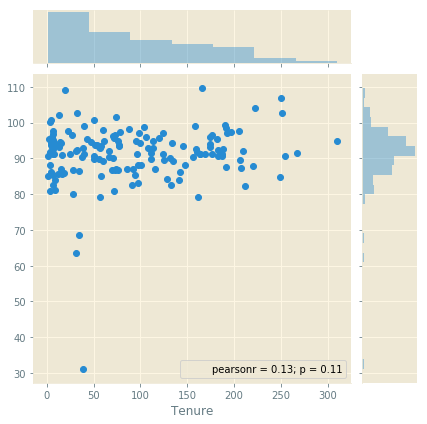

In [21]:
yhat = lr_70_30.predict(X_test)
sns.jointplot(y_test, yhat);

In [22]:
sum_cross_predicted_r2 = []

for folds in range(5,11):
    print('*____*____*____*____*____*____*____*____*')
    print('k: {}'.format(folds))
    model = LinearRegression()
    scores = cross_val_score(model, X, y, cv=folds)
#     cross_val_scores += scores.mean()
    print("Mean CV R2: {}".format(np.mean(scores)))
    print('Std CV R2: {}'.format(np.std(scores)))
    predictions = cross_val_predict(model, X, y, cv=folds)
    r2 = metrics.r2_score(y, predictions)
    print("Cross-Predicted R2: {}".format(r2))
    sum_cross_predicted_r2.append(r2)

print('-____-____-____-____-____-____-____-____-')
print('Mean cross-predicted r2 scores: {}'.format(np.asarray(sum_cross_predicted_r2).mean()))
    

*____*____*____*____*____*____*____*____*
k: 5
Mean CV R2: -0.014381337344978373
Std CV R2: 0.010643667214268734
Cross-Predicted R2: 0.0014859054890008494
*____*____*____*____*____*____*____*____*
k: 6
Mean CV R2: -0.024620917490801458
Std CV R2: 0.019709376515098083
Cross-Predicted R2: -0.002824117482886024
*____*____*____*____*____*____*____*____*
k: 7
Mean CV R2: -0.025125538583178213
Std CV R2: 0.02163371554012856
Cross-Predicted R2: -0.002040073394506292
*____*____*____*____*____*____*____*____*
k: 8
Mean CV R2: -0.016474905868487544
Std CV R2: 0.02560440894002334
Cross-Predicted R2: 0.0023252495496890457
*____*____*____*____*____*____*____*____*
k: 9
Mean CV R2: -0.02743347354186844
Std CV R2: 0.030082435156481905
Cross-Predicted R2: 0.000604799488328811
*____*____*____*____*____*____*____*____*
k: 10
Mean CV R2: -0.025115322171755973
Std CV R2: 0.030406646842154383
Cross-Predicted R2: 0.0008004911873438214
-____-____-____-____-____-____-____-____-
Mean cross-predicted r2 scores: